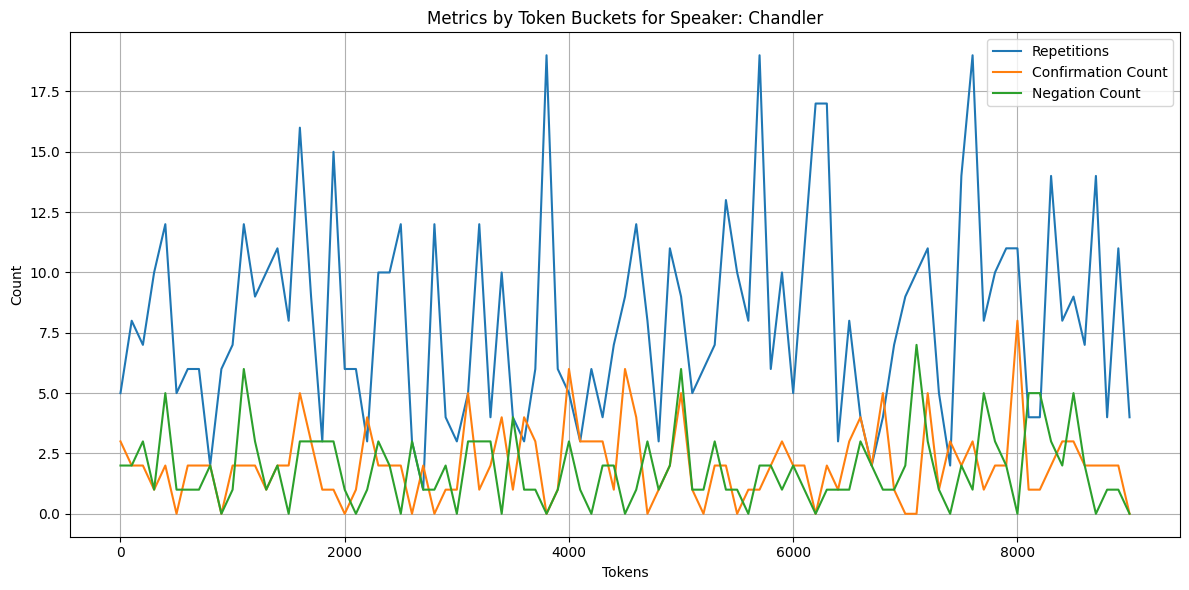

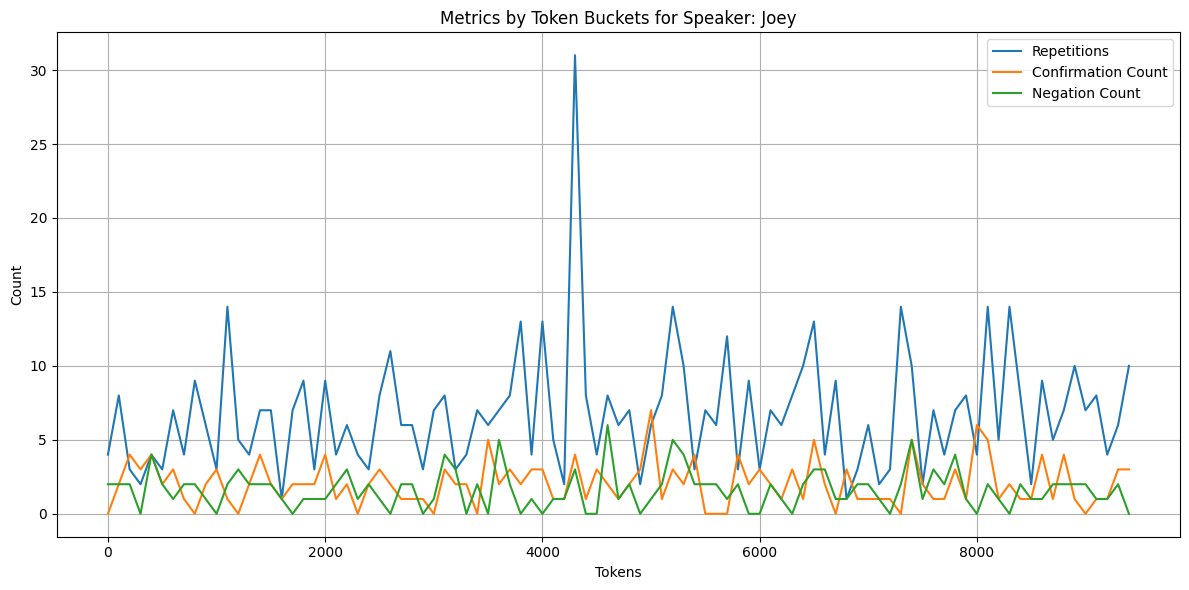

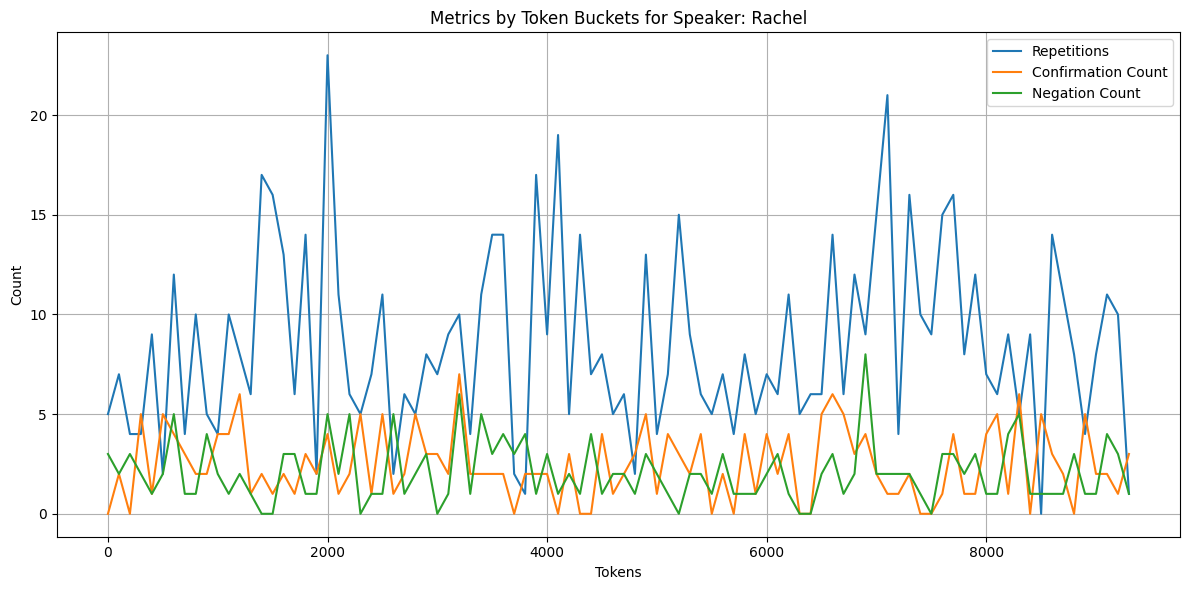

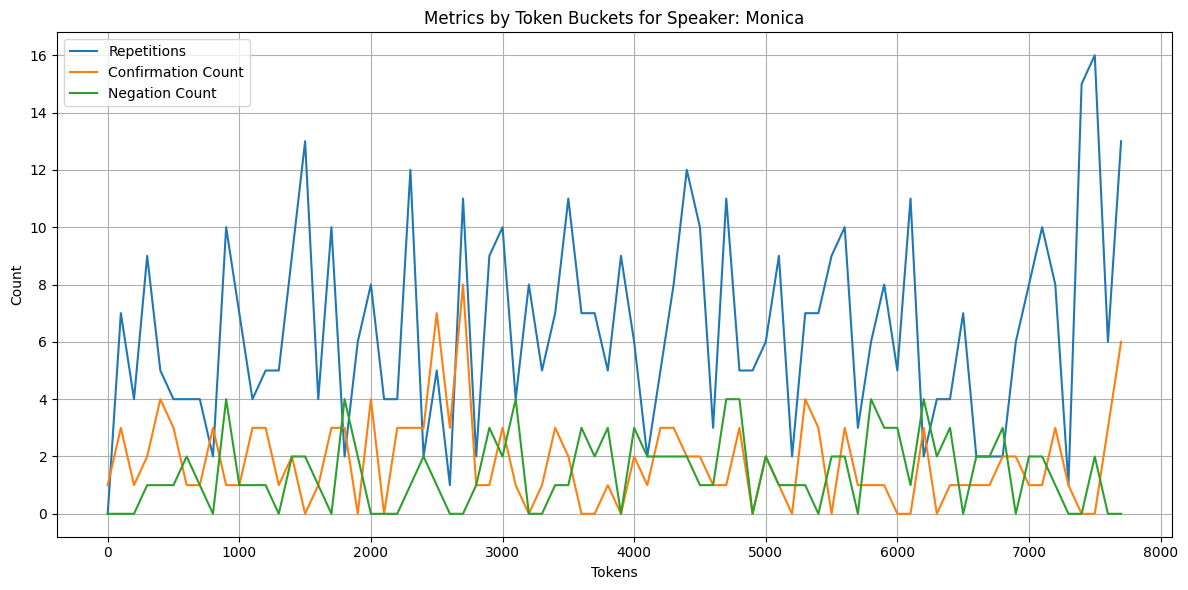

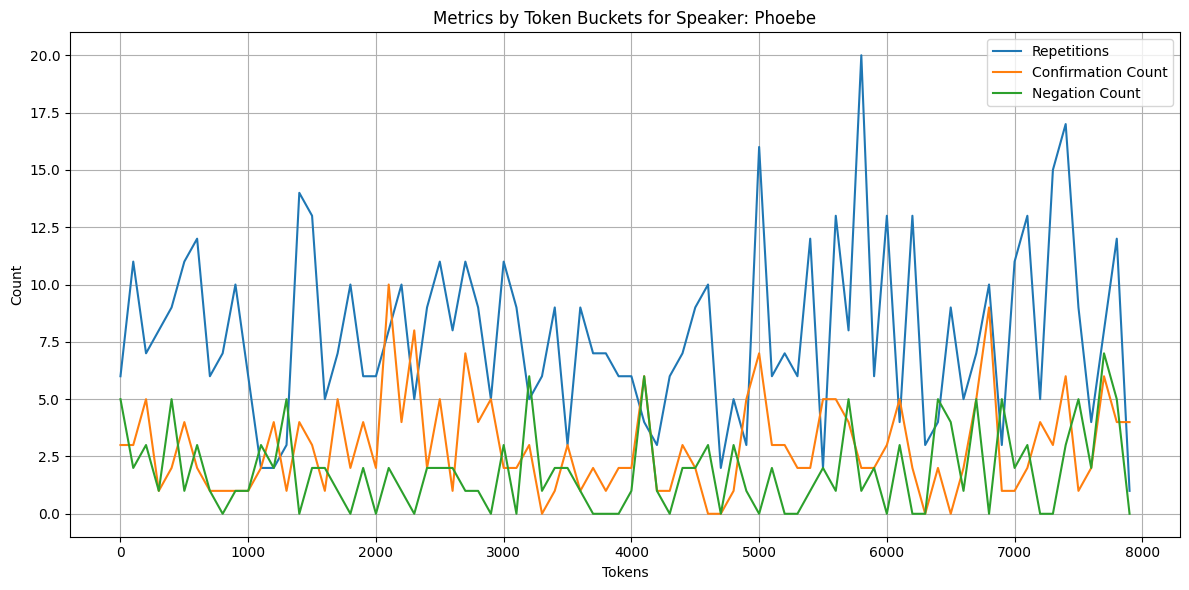

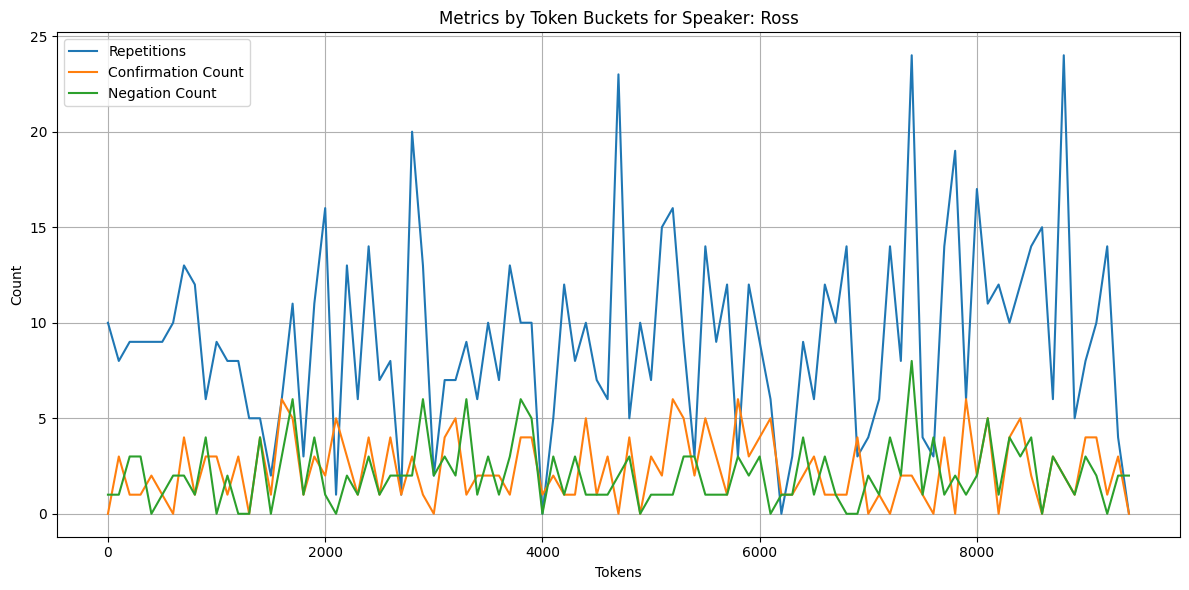

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np

# Define your words sets
confirmation_words = {'yes', 'yeah', 'yep', 'okay', 'alright', 'sure', 'absolutely', 'certainly', 'of course', 'indeed', 'definitely'}
negation_words = {'no', 'not', 'never', 'none', 'nor', 'nobody', 'neither', "don't", "isn't", "wasn't", "weren't", "doesn't", "won't", "haven't"}
stop_words = {'the', 'a', 't', ''}

def preprocess(tokens):
    return [
        token.translate(str.maketrans('', '', string.punctuation)).lower()
        for token in tokens if token not in stop_words
    ]

def calculate_row_metrics(speaker_df):
    # Metrics per row
    all_tokens = []
    token_sizes = []
    repetitions = []
    confirmation_counts = []
    negation_counts = []

    for _, row in speaker_df.iterrows():
        tokens = row['Utterance_1'].split()
        tokens = preprocess(tokens)
        all_tokens.append(tokens)

        # Token size
        token_size = len(tokens)
        token_sizes.append(token_size)

        # Word counts
        word_counts = Counter(tokens)
        
        # Calculations
        repetition_count = sum(count - 1 for word, count in word_counts.items() if count > 1)
        repetitions.append(repetition_count)

        confirmation_count = sum(count for word, count in word_counts.items() if word in confirmation_words)
        confirmation_counts.append(confirmation_count)

        negation_count = sum(count for word, count in word_counts.items() if word in negation_words)
        negation_counts.append(negation_count)

    speaker_df['Tokens'] = all_tokens
    speaker_df['Token Size'] = token_sizes
    speaker_df['Repetitions'] = repetitions
    speaker_df['Confirmation Count'] = confirmation_counts
    speaker_df['Negation Count'] = negation_counts

    return speaker_df

def calculate_bucket_metrics(speaker_df, bucket_size=100):
    # Cumulative token counter
    cumulative_tokens = 0
    bucket_metrics = {
        'Bucket': [],
        'Repetitions': [],
        'Confirmation Count': [],
        'Negation Count': []
    }
    
    current_bucket = 0
    bucket_repetitions = 0
    bucket_confirmations = 0
    bucket_negations = 0

    for _, row in speaker_df.iterrows():
        # Get counts for this utterance
        token_size = row['Token Size']
        cumulative_tokens += token_size

        # If we're in the same bucket, keep adding
        while cumulative_tokens > (current_bucket + 1) * bucket_size:
            # Save current bucket metrics
            bucket_metrics['Bucket'].append(current_bucket * bucket_size)
            bucket_metrics['Repetitions'].append(bucket_repetitions)
            bucket_metrics['Confirmation Count'].append(bucket_confirmations)
            bucket_metrics['Negation Count'].append(bucket_negations)
            
            # Reset metrics for the next bucket
            current_bucket += 1
            bucket_repetitions = 0
            bucket_confirmations = 0
            bucket_negations = 0

        # Add current row metrics to current bucket
        bucket_repetitions += row['Repetitions']
        bucket_confirmations += row['Confirmation Count']
        bucket_negations += row['Negation Count']

    # Add last bucket if not empty
    if bucket_repetitions > 0 or bucket_confirmations > 0 or bucket_negations > 0:
        bucket_metrics['Bucket'].append(current_bucket * bucket_size)
        bucket_metrics['Repetitions'].append(bucket_repetitions)
        bucket_metrics['Confirmation Count'].append(bucket_confirmations)
        bucket_metrics['Negation Count'].append(bucket_negations)
    
    return pd.DataFrame(bucket_metrics)

def calculate_metrics(speaker_df):

    tokens = [token for sublist in speaker_df['Tokens'].values for token in sublist]
    total_tokens = len(tokens)
    
    vocabulary_set = set(tokens)
    vocabulary_size = len(vocabulary_set)

    total_repetitions = sum(speaker_df['Repetitions'].values)
    total_confirmations = sum(speaker_df['Confirmation Count'].values)
    total_negations = sum(speaker_df['Negation Count'].values)
    
    metrics = {}
    metrics['Vocabulary Size'] = vocabulary_size
    metrics['Total Tokens'] = total_tokens
    metrics['Total Repetitions'] = total_repetitions
    metrics['Total Confirmations'] = total_confirmations
    metrics['Total Negations'] = total_negations
    
    return metrics

def calculate_average_personality(speaker_df):
    personality_columns = ['Personality']
    averages = {trait: eval(speaker_df[trait].iloc[0]) for trait in personality_columns}
    return averages

# Load your data
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)

# Create a dictionary of DataFrames with each subset being a copy of the relevant data
speakers = df['Speaker_1'].unique()
speaker_dfs = {speaker: df[df['Speaker_1'] == speaker].copy() for speaker in speakers}

all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in speaker_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [2]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
Chandler,1621,9025,734,186,169
Joey,1621,9454,641,194,154
Rachel,1429,9392,800,229,195
Monica,1492,7796,501,141,112
Phoebe,1479,7913,626,233,149
Ross,1557,9411,865,222,196


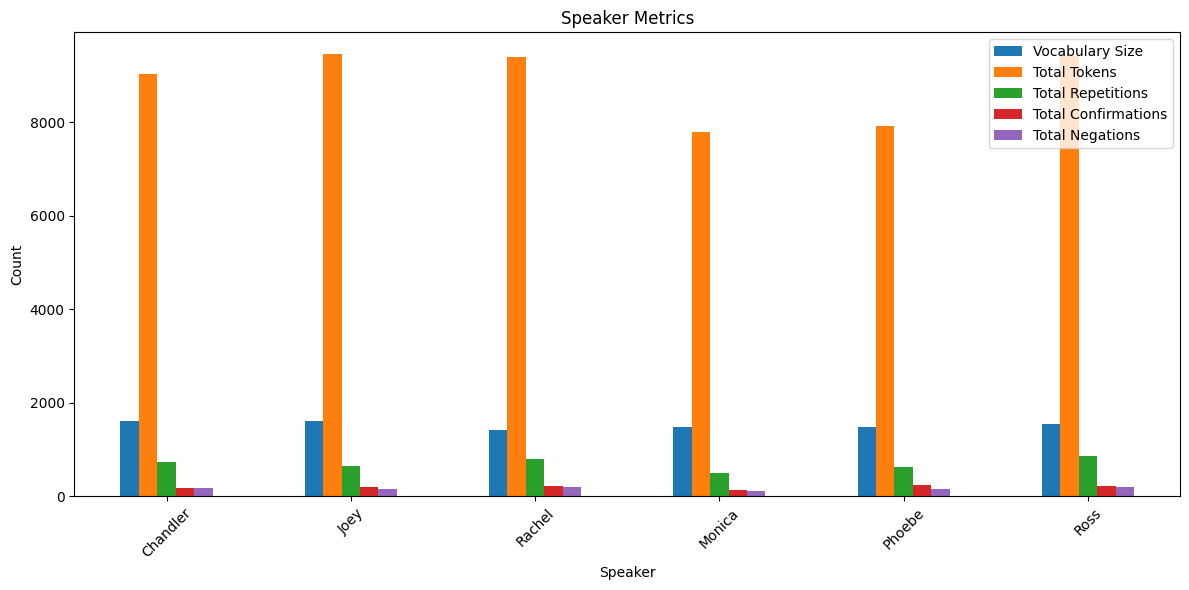

In [3]:
df_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Speaker Metrics')
plt.ylabel('Count')
plt.xlabel('Speaker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import ast

# Define a function to extract the dominant personality
def get_dominant_personality(row):
    # Convert the string representation of the list to an actual list of floats
    trait_probabilities = ast.literal_eval(row['Personality'])
    max_trait_index = np.argmax(trait_probabilities)
    
    return max_trait_index

# Apply this function to each row in df_raw and assign result to 'Dominant Personality' column
df['Dominant Personality'] = df.apply(get_dominant_personality, axis=1)

# Print the value counts of the 'Dominant Personality' column
print(df['Dominant Personality'].value_counts())

# Convert the values in the 'Dominant Personality' column to int and store them in a list
dominant_personalities = df['Dominant Personality'].tolist()
dominant_personalities = [int(x) for x in dominant_personalities]

print(dominant_personalities)


Dominant Personality
0    5387
1    1123
Name: count, dtype: int64
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
import pandas as pd

personality_dfs = {}
for personality in df['Dominant Personality'].unique():
    personality_dfs[personality] = df[df['Dominant Personality'] == personality]


# Example: Print the first few rows of each dataframe
for personality, dataframe in personality_dfs.items():
    print(f"Dominant Personality {personality}:")
    print(dataframe.head())


Dominant Personality 0:
  Speaker_1        Speaker_2                         Personality  \
0  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
1  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
2  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
3  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
4  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   

                                         Utterance_1  \
0  also I was the point person on my company s tr...   
1                            That I did. That I did.   
2                             My duties?  All right.   
3                                             I see.   
4                                      Good to know.   

                                         Utterance_2              Utterance_3  \
0                   You must ve had your hands full.  That I did. That I did.   
1      So let s talk a little bit about your duties.   My duties?  A

C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\301567635.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Tokens'] = all_tokens
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\301567635.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Token Size'] = token_sizes
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\301567635.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

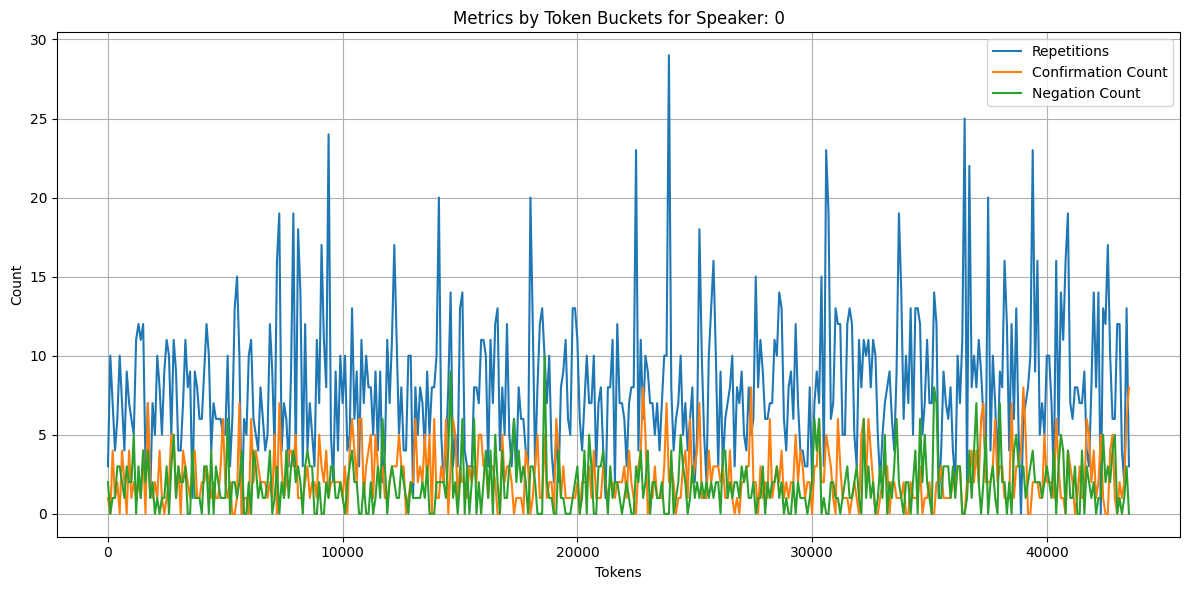

C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\301567635.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Tokens'] = all_tokens
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\301567635.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Token Size'] = token_sizes
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\301567635.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

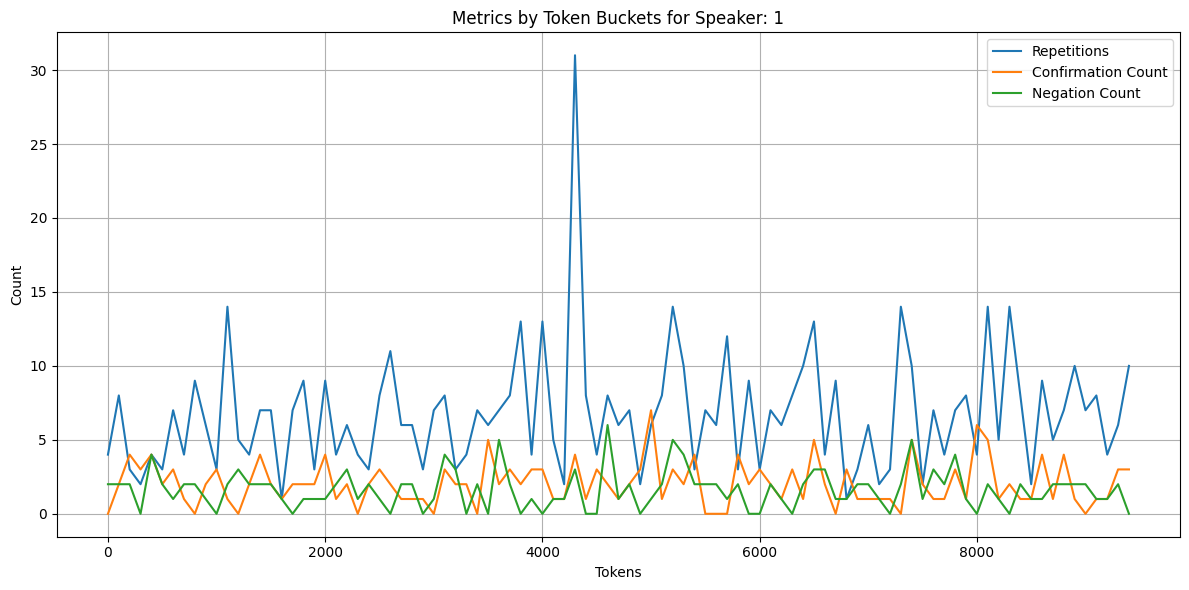

In [6]:
all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in personality_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [7]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
0,4022,43537,3526,1011,821
1,1621,9454,641,194,154


In [8]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity

# Combine all text in the 'Utterance_1' column for each speaker into a single string
combined_texts = {speaker: " ".join(speaker_df['Utterance_1'].tolist()) for speaker, speaker_df in speaker_dfs.items()}

# Prepare data for doc2vec
documents = [TaggedDocument(words=text.split(), tags=[speaker]) for speaker, text in combined_texts.items()]

# Train doc2vec model
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Function to generate embeddings using doc2vec
def generate_embedding(text):
    return model.infer_vector(text.split())

# Personality trait definitions with both sides of the spectrum
personality_definitions = {
    'Extraversion': [('Talkative', 'Silent'), ('Sociable', 'Reclusive'), ('Adventurous', 'Cautious'), ('Open', 'Secretive')],
    'Agreeableness': [('Good-natured', 'Irritable'), ('Cooperative', 'Negativistic'), ('Mild', 'Headstrong'), ('Not jealous', 'Jealous')],
    'Conscientiousness': [('Responsible', 'Undependable'), ('Scrupulous', 'Unscrupulous'), ('Persevering', 'Quitting'), ('Fussy', 'Careless')],
    'Emotional Stability': [('Calm', 'Anxious'), ('Composed', 'Excitable'), ('Not hypochondriacal', 'Hypochondriacal'), ('Poised', 'Nervous')],
    'Culture/Intellect, Openness': [('Intellectual', 'Unreflective'), ('Artistic', 'Non artistic'), ('Imaginative', 'Simple'), ('Polished', 'Crude')]
}

# Generate embeddings for both sides of each trait spectrum
personality_embeddings = {}
for trait, definitions in personality_definitions.items():
    personality_embeddings[trait] = [(generate_embedding(defn[0]), generate_embedding(defn[1])) for defn in definitions]

# Function to compute the position on the spectrum for a trait
def compute_trait_position(dataframe_embedding, trait_embeddings):
    positions = []
    for pos_emb, neg_emb in trait_embeddings:
        pos_score = cosine_similarity([dataframe_embedding], [pos_emb])[0][0]
        neg_score = cosine_similarity([dataframe_embedding], [neg_emb])[0][0]
        position = pos_score - neg_score  # Positive if closer to positive side, negative if closer to negative side
        positions.append(position)
    return np.mean(positions)  # Average position for the trait

# Process each speaker's combined text
for speaker, combined_text in combined_texts.items():
    # Generate embedding for the combined text
    combined_embedding = generate_embedding(combined_text)
    
    # Compute positions for each trait
    trait_positions = {}
    for trait, embeddings in personality_embeddings.items():
        trait_positions[trait + '_Position'] = compute_trait_position(combined_embedding, embeddings)
    
    # Print the results for the current speaker
    print(f"Results for {speaker}:")
    for trait, position in trait_positions.items():
        print(f"{trait}: {position}")


Results for Chandler:
Extraversion_Position: 0.07062490284442902
Agreeableness_Position: 0.2904547154903412
Conscientiousness_Position: 0.10165619850158691
Emotional Stability_Position: 0.4128674566745758
Culture/Intellect, Openness_Position: 0.03694017231464386
Results for Joey:
Extraversion_Position: 0.03229531645774841
Agreeableness_Position: 0.24215616285800934
Conscientiousness_Position: 0.17155587673187256
Emotional Stability_Position: 0.3713236451148987
Culture/Intellect, Openness_Position: 0.0022684354335069656
Results for Rachel:
Extraversion_Position: 0.10072886943817139
Agreeableness_Position: 0.2670113444328308
Conscientiousness_Position: 0.07610926032066345
Emotional Stability_Position: 0.32917946577072144
Culture/Intellect, Openness_Position: 0.09470640122890472
Results for Monica:
Extraversion_Position: 0.1576898694038391
Agreeableness_Position: 0.27408158779144287
Conscientiousness_Position: 0.16056984663009644
Emotional Stability_Position: 0.34262847900390625
Culture/I